Upload TVs-all-merged.zip now:


Saving TVs-all-merged.zip to TVs-all-merged.zip
Number of products: 1624
Total gold duplicate pairs: 399
Total possible pairs: 1317876

LSH EXTENSION FIRST (HYBRID REP: brand + model words + top title tokens)

Avg rep tokens per product: 8.652093596059114

--- Bootstrap 1/5 ---
h120_b60_r2: pairs=47685, PQ=0.001, PC=0.984, F1*=0.003, F1_class=0.206, thr=0.42
h120_b40_r3: pairs=6402, PQ=0.008, PC=0.778, F1*=0.015, F1_class=0.206, thr=0.42
h120_b30_r4: pairs=1326, PQ=0.019, PC=0.397, F1*=0.036, F1_class=0.198, thr=0.48
h120_b20_r6: pairs=123, PQ=0.041, PC=0.079, F1*=0.054, F1_class=0.099, thr=0.46

--- Bootstrap 2/5 ---
h120_b60_r2: pairs=44439, PQ=0.001, PC=0.967, F1*=0.003, F1_class=0.212, thr=0.46
h120_b40_r3: pairs=6599, PQ=0.006, PC=0.656, F1*=0.012, F1_class=0.212, thr=0.46
h120_b30_r4: pairs=1408, PQ=0.016, PC=0.377, F1*=0.031, F1_class=0.229, thr=0.46
h120_b20_r6: pairs=32, PQ=0.125, PC=0.066, F1*=0.086, F1_class=0.056, thr=0.46

--- Bootstrap 3/5 ---
h120_b60_r2: pairs=27570, PQ

,setting,avg_fraction,avg_PQ,avg_PC,avg_F1*,avg_F1_class
3,h120_b20_r6,0.000076,0.070774,0.071218,0.058959,0.036747
2,h120_b30_r4,0.000965,0.014514,0.321965,0.027737,0.152320
1,h120_b40_r3,0.008359,0.005493,0.650182,0.010872,0.168291
0,h120_b60_r2,0.030131,0.001469,0.963901,0.002933,0.157836


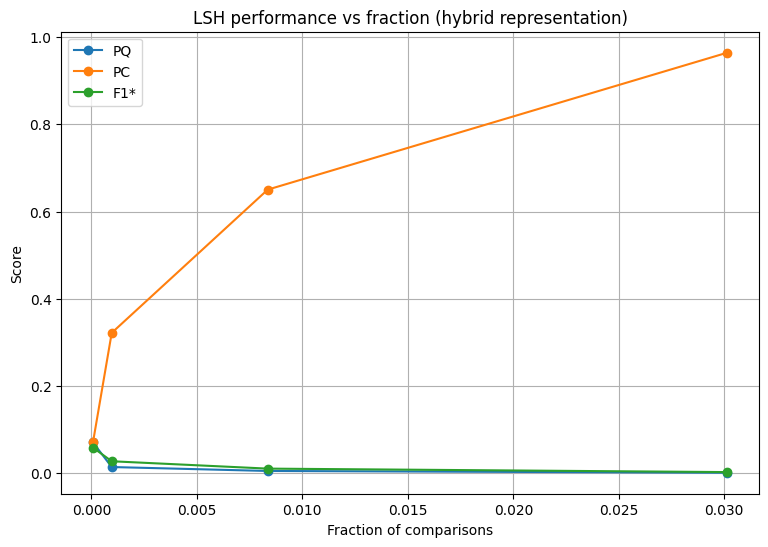

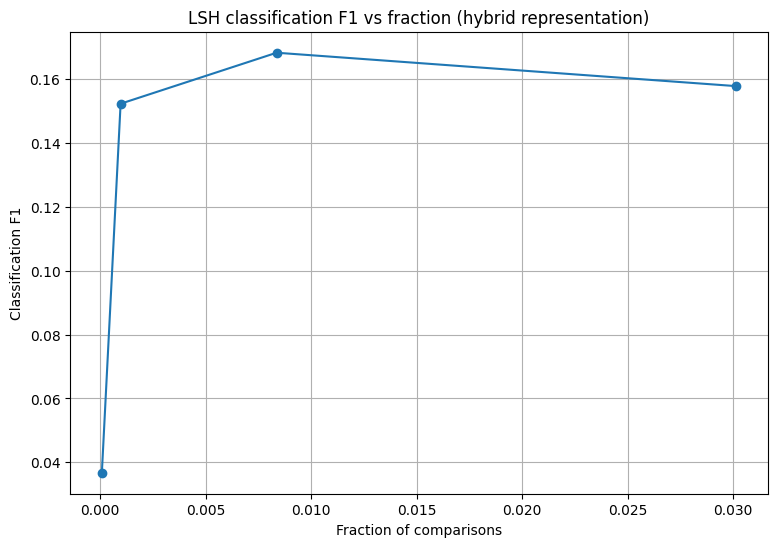


NOW COMPUTING MSM BASELINE

Computing MSM similarities (this takes a few minutes)...

=== MSM baseline results ===
Threshold: 0.6300000000000001
PQ = 0.35323383084489246
PC = 0.3669250645985351
F1 = 0.3599493024143507


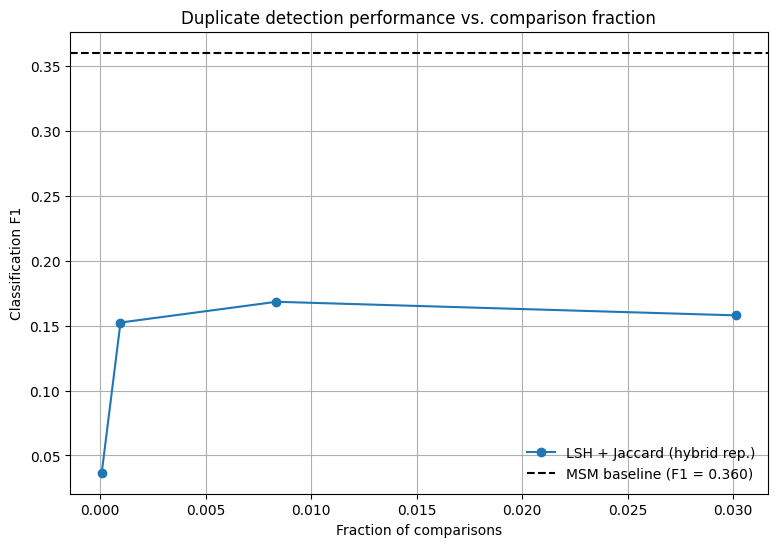


Done. You can now download:
 - lsh_results_hybrid_rep.csv
 - lsh_pq_pc_f1star.png
 - lsh_f1class.png
 - lsh_vs_msm_f1class.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import json, zipfile, os, re, time, random
from collections import defaultdict, Counter
from itertools import combinations

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from hashlib import md5
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity

N_BOOTSTRAPS = 5
NUM_HASHES   = 120
Q_GRAM       = 3
SAVE_PLOTS   = True

# LSH banding settings (bands * rows = NUM_HASHES)
LSH_SETTINGS = [
    {"bands": 60, "rows": 2},
    {"bands": 40, "rows": 3},
    {"bands": 30, "rows": 4},
    {"bands": 20, "rows": 6},
]

RNG = np.random.RandomState(42)
random.seed(42)

for s in LSH_SETTINGS:
    assert s["bands"] * s["rows"] == NUM_HASHES

# Load data
from google.colab import files
print("Upload TVs-all-merged.zip now:")
uploaded = files.upload()
zip_filename = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_filename, "r") as z:
    z.extractall("data")

json_files = [f for f in os.listdir("data") if f.endswith(".json")]
json_path = os.path.join("data", json_files[0])

with open(json_path, "r", encoding="utf-8") as f:
    raw = json.load(f)

records = []
for modelID, prods in raw.items():
    for p in prods:
        p["modelID"] = modelID
        records.append(p)

df = pd.DataFrame(records).reset_index(drop=True)
n = len(df)

print("Number of products:", n)

# Data cleaning
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    t = text.lower()
    t = re.sub(r"[^a-z0-9 ]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["clean_title"] = df["title"].apply(normalize_text)
df["clean_features"] = df["featuresMap"].apply(
    lambda m: {k: normalize_text(str(v)) for k, v in m.items()}
)

model_counts = df["modelID"].value_counts()
total_duplicates = int(sum(m*(m-1)//2 for m in model_counts if m > 1))
total_pairs      = n*(n-1)//2

def is_duplicate(i, j):
    return df.at[i,"modelID"] == df.at[j,"modelID"] and df.at[i,"shop"] != df.at[j,"shop"]

print("Total gold duplicate pairs:", total_duplicates)
print("Total possible pairs:", total_pairs)

# LSH

STOPWORDS = {
    "led","lcd","hdtv","tv","inch","inches","with","and","or",
    "smart","series","class","full","hd","ultra","uhd","3d","wifi",
    "black","silver","white","screen","flat","wide"
}

def is_model_word(tok: str) -> bool:
    """Token that contains at least one letter AND one digit."""
    has_digit = any(c.isdigit() for c in tok)
    has_alpha = any(c.isalpha() for c in tok)
    return has_digit and has_alpha

def extract_model_words_from_row(row) -> set:
    # from title + all attribute values
    text = row["clean_title"] + " " + " ".join(row["clean_features"].values())
    toks = text.split()
    return {t for t in toks if is_model_word(t)}

def top_title_tokens(row, k=3) -> set:
    toks = [t for t in row["clean_title"].split() if t and t not in STOPWORDS]
    return set(toks[:k])

def brand_token(row) -> set:
    brand = row["clean_features"].get("brand", "")
    return {brand} if brand else set()

def build_representation(row) -> set:
    """Hybrid representation C: model words + brand + top-3 title tokens."""
    rep = set()
    rep |= extract_model_words_from_row(row)
    rep |= top_title_tokens(row, k=3)
    rep |= brand_token(row)
    return rep

df["rep_tokens"] = df.apply(build_representation, axis=1)
print("Avg rep tokens per product:", df["rep_tokens"].apply(len).mean())

# Token hashing
def token_to_int(tok):
    return int(md5(tok.encode("utf-8")).hexdigest(), 16) % (2**31 - 1)

df["rep_ids"] = df["rep_tokens"].apply(lambda S: set(token_to_int(t) for t in S))

# MinHash
PRIME = 4294967311

def make_hash_params(num_hashes):
    a = RNG.randint(1, PRIME-1, num_hashes)
    b = RNG.randint(0, PRIME-1, num_hashes)
    return a, b

def compute_signature(id_set, a, b):
    """MinHash signature for a set of ints."""
    if not id_set:
        return [2**32-1]*len(a)
    sig = []
    for ai, bi in zip(a, b):
        m = PRIME
        for x in id_set:
            hv = (ai * x + bi) % PRIME
            if hv < m:
                m = hv
        sig.append(int(m))
    return sig

def lsh_buckets(signatures, bands, rows, idx_list):
    B = [defaultdict(list) for _ in range(bands)]
    for idx in idx_list:
        sig = signatures[idx]
        for b in range(bands):
            part = tuple(sig[b*rows:(b+1)*rows])
            B[b][part].append(idx)
    return B

def candidate_pairs(B):
    out = set()
    for band in B:
        for idxs in band.values():
            if len(idxs) > 1:
                for i in range(len(idxs)):
                    for j in range(i+1, len(idxs)):
                        a,b = idxs[i], idxs[j]
                        out.add((a,b) if a<b else (b,a))
    return out

def jaccard(A,B):
    if not A and not B: return 0.0
    return len(A & B)/len(A|B)

# Improve PQ
def same_brand(i, j):
    bi = df.at[i, "clean_features"].get("brand", "")
    bj = df.at[j, "clean_features"].get("brand", "")
    if not bi or not bj:
        return True
    return bi == bj

def approx_same_size(i, j, tol=3):
    feats_i = df.at[i, "clean_features"]
    feats_j = df.at[j, "clean_features"]
    size_keys_i = [k for k in feats_i.keys() if "screen" in k or "size" in k]
    size_keys_j = [k for k in feats_j.keys() if "screen" in k or "size" in k]
    if not size_keys_i or not size_keys_j:
        return True
    k_i = size_keys_i[0]
    k_j = size_keys_j[0]
    try:
        si = float(re.findall(r"\d+(\.\d+)?", feats_i[k_i])[0])
        sj = float(re.findall(r"\d+(\.\d+)?", feats_j[k_j])[0])
        return abs(si - sj) <= tol
    except Exception:
        return True

results_lsh = {
    f"h{NUM_HASHES}_b{s['bands']}_r{s['rows']}": {
        "PQ":[], "PC":[], "F1*":[], "F1_class":[], "fraction":[]
    }
    for s in LSH_SETTINGS
}

indices = np.arange(n)

for b_idx in range(N_BOOTSTRAPS):
    print(f"" Bootstrap {b_idx+1}/{N_BOOTSTRAPS} ---")

    boot = RNG.choice(indices, size=n, replace=True)
    train = sorted(set(boot))
    test  = sorted(set(indices)-set(train))

    # Compute signatures
    a_params, b_params = make_hash_params(NUM_HASHES)
    signatures = [
        compute_signature(df.at[i,"rep_ids"], a_params, b_params)
        for i in range(n)
    ]

    # Count true duplicates
    test_dup_pairs = [
        (i,j) for i in test for j in test
        if i<j and is_duplicate(i,j)
    ]
    total_dup_test = len(test_dup_pairs)

    for setting in LSH_SETTINGS:
        bands = setting["bands"]; rows = setting["rows"]
        key   = f"h{NUM_HASHES}_b{bands}_r{rows}"

        # Tune Jaccard threshold
        Btrain = lsh_buckets(signatures, bands, rows, train)
        train_cands = candidate_pairs(Btrain)

        filtered_train = []
        for (i,j) in train_cands:
            if df.at[i,"shop"] == df.at[j,"shop"]:
                continue
            if not same_brand(i, j):       # extra blocking
                continue
            if not approx_same_size(i, j): # extra blocking
                continue
            filtered_train.append((i,j))
        train_cands = filtered_train

        train_scores = []
        train_labels = []
        for i,j in train_cands:
            s = jaccard(df.at[i,"rep_tokens"], df.at[j,"rep_tokens"])
            train_scores.append(s)
            train_labels.append(1 if is_duplicate(i,j) else 0)

        best_thresh = 0.3
        if train_labels and sum(train_labels) > 0:
            best_f1 = -1
            # hyperparameter tuning of Jaccard threshold
            for t in np.linspace(0.1, 0.9, 41):
                preds = [1 if sc>=t else 0 for sc in train_scores]
                _,_,f,_ = precision_recall_fscore_support(
                    train_labels, preds, average="binary", zero_division=0
                )
                if f > best_f1:
                    best_f1 = f
                    best_thresh = t

        Btest = lsh_buckets(signatures, bands, rows, test)
        test_cands = candidate_pairs(Btest)

        filtered_test = []
        for (i,j) in test_cands:
            if df.at[i,"shop"] == df.at[j,"shop"]:
                continue
            if not same_brand(i, j):
                continue
            if not approx_same_size(i, j):
                continue
            filtered_test.append((i,j))
        test_cands = filtered_test

        # Pair quality / completeness
        dup_found = sum(is_duplicate(i,j) for (i,j) in test_cands)
        PQ = dup_found / (len(test_cands) + 1e-9)
        PC = dup_found / (total_dup_test + 1e-9) if total_dup_test>0 else 0
        F1_star = 2*PQ*PC/(PQ+PC+1e-9) if PQ+PC>0 else 0

        # Classification F1 using tuned threshold
        TP = FP = 0
        for (i,j) in test_cands:
            s = jaccard(df.at[i,"rep_tokens"], df.at[j,"rep_tokens"])
            pred = (s >= best_thresh)
            truth = is_duplicate(i,j)
            if pred and truth: TP += 1
            elif pred and not truth: FP += 1

        FN = total_dup_test - TP
        prec = TP/(TP+FP+1e-9)
        rec  = TP/(TP+FN+1e-9)
        F1_class = 2*prec*rec/(prec+rec+1e-9) if prec+rec > 0 else 0

        fraction = len(test_cands)/total_pairs

        results_lsh[key]["PQ"].append(PQ)
        results_lsh[key]["PC"].append(PC)
        results_lsh[key]["F1*"].append(F1_star)
        results_lsh[key]["F1_class"].append(F1_class)
        results_lsh[key]["fraction"].append(fraction)

        print(f"{key}: pairs={len(test_cands)}, PQ={PQ:.3f}, PC={PC:.3f}, F1*={F1_star:.3f}, F1_class={F1_class:.3f}, thr={best_thresh:.2f}")

# LSH results
agg_rows = []
for key, val in results_lsh.items():
    agg_rows.append([
        key,
        np.mean(val["fraction"]),
        np.mean(val["PQ"]),
        np.mean(val["PC"]),
        np.mean(val["F1*"]),
        np.mean(val["F1_class"])
    ])

agg_df = pd.DataFrame(
    agg_rows,
    columns=["setting","avg_fraction","avg_PQ","avg_PC","avg_F1*","avg_F1_class"]
).sort_values("avg_fraction")

print("\nAggregated LSH results:")
display(agg_df)

agg_df.to_csv("lsh_results_hybrid_rep.csv", index=False)

# PLOTS
plt.figure(figsize=(9,6))
plt.plot(agg_df["avg_fraction"], agg_df["avg_PQ"], "o-", label="PQ")
plt.plot(agg_df["avg_fraction"], agg_df["avg_PC"], "o-", label="PC")
plt.plot(agg_df["avg_fraction"], agg_df["avg_F1*"], "o-", label="F1*")
plt.xlabel("Fraction of comparisons")
plt.ylabel("Score")
plt.title("LSH performance vs fraction (hybrid representation)")
plt.grid(True)
plt.legend()
if SAVE_PLOTS: plt.savefig("lsh_pq_pc_f1star.png", dpi=200, bbox_inches="tight")
plt.show()

plt.figure(figsize=(9,6))
plt.plot(agg_df["avg_fraction"], agg_df["avg_F1_class"], "o-")
plt.xlabel("Fraction of comparisons")
plt.ylabel("Classification F1")
plt.title("LSH classification F1 vs fraction (hybrid representation)")
plt.grid(True)
if SAVE_PLOTS: plt.savefig("lsh_f1class.png", dpi=200, bbox_inches="tight")
plt.show()

# MSM BASELINE
print("MSM baseline")

# TF-IDF for title
tfidf = TfidfVectorizer()
title_matrix = tfidf.fit_transform(df["clean_title"])

def qgrams(s, q=3):
    s2 = "##"+s+"##"
    if len(s2)<q:
        return {s2}
    return {s2[i:i+q] for i in range(len(s2)-q+1)}

def qgram_sim(a,b,q=3):
    A=qgrams(a,q); B=qgrams(b,q)
    return len(A&B)/len(A|B) if A|B else 0

# model words
def extract_model_words(text):
    toks = re.sub(r"[^a-z0-9 ]"," ",text).split()
    return set(t for t in toks if is_model_word(t))

# MSM similarity
def msm_similarity(i,j):
    A=df.loc[i]; B=df.loc[j]
    if A["shop"]==B["shop"]:
        return 0.0

    featsA=A["clean_features"]; featsB=B["clean_features"]
    keysA=set(featsA.keys()); keysB=set(featsB.keys())

    # Brand filtering
    if "brand" in featsA and "brand" in featsB:
        if featsA["brand"] != featsB["brand"]:
            return 0.0

    # Part 1: KVP q-gram
    matched = keysA & keysB
    kv_vals=[]
    for k in matched:
        kv_vals.append(qgram_sim(featsA[k], featsB[k], Q_GRAM))
    avgSim = np.mean(kv_vals) if kv_vals else 0

    min_keys = min(len(keysA), len(keysB)) or 1
    w1 = len(matched)/min_keys

    # Part 2: model words on unmatched values
    unmatchedA=" ".join(featsA[k] for k in (keysA-matched))
    unmatchedB=" ".join(featsB[k] for k in (keysB-matched))
    mwA = extract_model_words(unmatchedA)
    mwB = extract_model_words(unmatchedB)
    mwPerc = len(mwA & mwB)/min(len(mwA),len(mwB)) if mwA and mwB else 0

    # Part 3: title cosine
    tSim = cosine_similarity(title_matrix[i],title_matrix[j])[0,0]

    remaining = 1-w1
    # bias slightly towards title similarity
    w3 = remaining * 0.7    # title
    w2 = remaining * 0.3    # model words
    return w1*avgSim + w2*mwPerc + w3*tSim

# MSM similarity
msm_scores=[]
msm_labels=[]

for i in range(n):
    for j in range(i+1,n):
        if df.at[i,"shop"] == df.at[j,"shop"]:
            continue
        s = msm_similarity(i,j)
        lab = 1 if is_duplicate(i,j) else 0
        msm_scores.append(s)
        msm_labels.append(lab)

msm_scores = np.array(msm_scores)
msm_labels = np.array(msm_labels)

# Hyperparameter tuning
best_t = 0.5
best_f1 = -1
for t in np.linspace(0.3, 0.9, 61):
    pred = (msm_scores>=t).astype(int)
    _,_,f,_=precision_recall_fscore_support(
        msm_labels,pred,average="binary",zero_division=0
    )
    if f>best_f1:
        best_f1 = f
        best_t = t

pred_final = (msm_scores>=best_t).astype(int)
TP = np.sum((pred_final==1)&(msm_labels==1))
FP = np.sum((pred_final==1)&(msm_labels==0))
FN = np.sum((pred_final==0)&(msm_labels==1))

PQ = TP/(TP+FP+1e-9)
PC = TP/(TP+FN+1e-9)
F1 = 2*PQ*PC/(PQ+PC+1e-9)

print("MSM baseline results")
print("Threshold:", best_t)
print("PQ =", PQ)
print("PC =", PC)
print("F1 =", F1)

plt.figure(figsize=(9,6))
plt.plot(
    agg_df["avg_fraction"],
    agg_df["avg_F1_class"],
    marker="o", linestyle="-", label="LSH + Jaccard (hybrid rep.)"
)
plt.axhline(
    y=F1,
    linestyle="--", color="black",
    label=f"MSM baseline (F1 = {F1:.3f})"
)
plt.xlabel("Fraction of comparisons")
plt.ylabel("Classification F1")
plt.title("Duplicate detection performance vs. comparison fraction")
plt.grid(True)
plt.legend(frameon=False)
if SAVE_PLOTS:
    plt.savefig("lsh_vs_msm_f1class.png", dpi=300, bbox_inches="tight")
plt.show()

print("\nDone. You can now download:")
print(" - lsh_results_hybrid_rep.csv")
print(" - lsh_pq_pc_f1star.png")
print(" - lsh_f1class.png")
print(" - lsh_vs_msm_f1class.png")

from google.colab import files
files.download("lsh_results_hybrid_rep.csv")
files.download("lsh_pq_pc_f1star.png")
files.download("lsh_f1class.png")
files.download("lsh_vs_msm_f1class.png")
